In [1]:
import idx2numpy
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

## Digits Extraction

In [2]:
# Loading Digits Dataset from MNIST
def load_data(label_file_path, image_file_path):
    labels = idx2numpy.convert_from_file(label_file_path)
    images = idx2numpy.convert_from_file(image_file_path).reshape(len(labels), -1) / 255.0
    return labels, images

def create_dataframe(labels, images):
    df = pd.DataFrame({'label': labels, 'img': list(images)})
    return df

In [3]:
# File paths
label_file_path = './Dataset/train-labels.idx1-ubyte'
image_file_path = './Dataset/train-images.idx3-ubyte'

In [4]:
# Load data
labels, images = load_data(label_file_path, image_file_path)

In [5]:
# Create DataFrame
num = create_dataframe(labels, images)
num

,label,img
0,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
59995,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59996,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59997,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59998,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Symbols Exraction

In [6]:
# Loading Symbols Dataset and converting the images to 1D array
symbols_dataset = pd.DataFrame(pd.read_pickle(r"./Dataset/data.pickle"))
symbols_dataset["img"] = symbols_dataset["img"].apply(lambda x: x.ravel())

In [7]:
symbols_dataset

,label,img
0,+,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,x,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,/,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,(,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
4895,x,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4896,/,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4897,(,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4898,),"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
symbols_dataset["label"].unique()

array(['+', '-', 'x', '/', '(', ')', ','], dtype=object)

In [9]:
# Coverting Labels of symbols into integers for training the model on neural networks
def symbols_convertion(symbol):
    if symbol == '+':
        return 10
    elif symbol == '-':
        return 11
    elif symbol == 'x':
        return 12
    elif symbol == '/':
        return 13
    elif symbol == '(':
        return 14
    elif symbol == ')':
        return 15
    elif symbol == ',':
        return 16

symbols_dataset["label"] = symbols_dataset["label"].apply(symbols_convertion)

In [10]:
symbols_dataset["label"]

0       10
1       11
2       12
3       13
4       14
        ..
4895    12
4896    13
4897    14
4898    15
4899    16
Name: label, Length: 4900, dtype: int64

## Data Augmentation

In [11]:
# Seperating the images from dataset and making a seperate Dataframe
num_img_df = pd.DataFrame(num["img"].to_list())
symbols_img_df = pd.DataFrame(symbols_dataset["img"].to_list())

In [12]:
symbols_img_df = symbols_img_df.values.reshape(-1, 28, 28, 1)
symbols_img_df

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [13]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [14]:
# How many time augmentation occurs on image
aug_factor = 9

In [15]:
# Augmentation is only applying on symbols because they are most likely to be wrong classified
img_aug = []
label_aug = []

for i in range(aug_factor):
    img_aug.extend(next(datagen.flow(symbols_img_df, batch_size=len(symbols_img_df), shuffle=False)))
    label_aug.append(symbols_dataset["label"])

label_aug = pd.concat(label_aug, ignore_index=True)

In [16]:
label_aug.shape

(44100,)

In [17]:
img_aug = np.array(img_aug).squeeze()
img_aug = img_aug.reshape(-1,28,28,1)
symbols_img_df = pd.DataFrame(img_aug.reshape(44100, 784))

In [18]:
symbols_img_df.shape

(44100, 784)

## Concatinating Both the datasets for Training

In [19]:
images = pd.concat([num_img_df, symbols_img_df], ignore_index=True)
labels = pd.concat([num["label"], label_aug], ignore_index=True)
print(images.shape)
print(labels.shape)

(104100, 784)
(104100,)


## Encoding

In [20]:
X = images
y = labels
X = X.values.reshape(-1,28,28,1)
y = to_categorical(y)

In [21]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

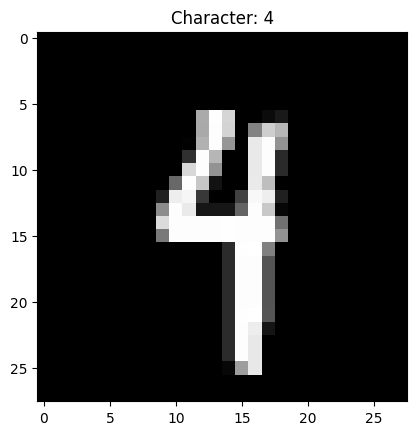

In [22]:
plt.imshow(train_X[60000][:, :, 0], cmap="gray")
plt.title(f"Character: {np.argmax(train_y[60000])}")
plt.show()

## Training With CNN

In [23]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(17, activation = "softmax"))

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 32)            │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 32)            │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │           4,369 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 237,617 (928.19 KB)

 Trainable params: 237,361 (927.19 KB)

 Non-trainable params: 256 (1.00 KB)

In [25]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=optimizer,loss=['categorical_crossentropy'],metrics=['accuracy'])

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
epochs=30
batch_size=64

In [28]:
history = model.fit(datagen.flow(train_X, train_y, batch_size=batch_size),
                    epochs = epochs, validation_data = (test_X, test_y),
                    verbose = 2, steps_per_epoch=train_X.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction])

model.save(filepath = "calculator_model.h5")

Epoch 1/30


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1301/1301 - 390s - 300ms/step - accuracy: 0.8881 - loss: 0.3553 - val_accuracy: 0.9778 - val_loss: 0.0699 - learning_rate: 0.0010
Epoch 2/30


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1301/1301 - 32s - 24ms/step - accuracy: 0.9531 - loss: 0.1174 - val_accuracy: 0.9788 - val_loss: 0.0655 - learning_rate: 0.0010
Epoch 3/30
1301/1301 - 386s - 297ms/step - accuracy: 0.9591 - loss: 0.1223 - val_accuracy: 0.9800 - val_loss: 0.0619 - learning_rate: 0.0010
Epoch 4/30
1301/1301 - 31s - 24ms/step - accuracy: 0.9688 - loss: 0.2005 - val_accuracy: 0.9821 - val_loss: 0.0530 - learning_rate: 0.0010
Epoch 5/30
1301/1301 - 422s - 325ms/step - accuracy: 0.9668 - loss: 0.1022 - val_accuracy: 0.9809 - val_loss: 0.0525 - learning_rate: 0.0010
Epoch 6/30
1301/1301 - 32s - 25ms/step - accuracy: 0.9688 - loss: 0.0810 - val_accuracy: 0.9795 - val_loss: 0.0547 - learning_rate: 0.0010
Epoch 7/30
1301/1301 - 396s - 304ms/step - accuracy: 0.9709 - loss: 0.0873 - val_accuracy: 0.9859 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 8/30
1301/1301 - 32s - 25ms/step - accuracy: 0.9688 - loss: 0.1087 - val_accuracy: 0.9854 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 9/30
1301/1301 - 397s - 30

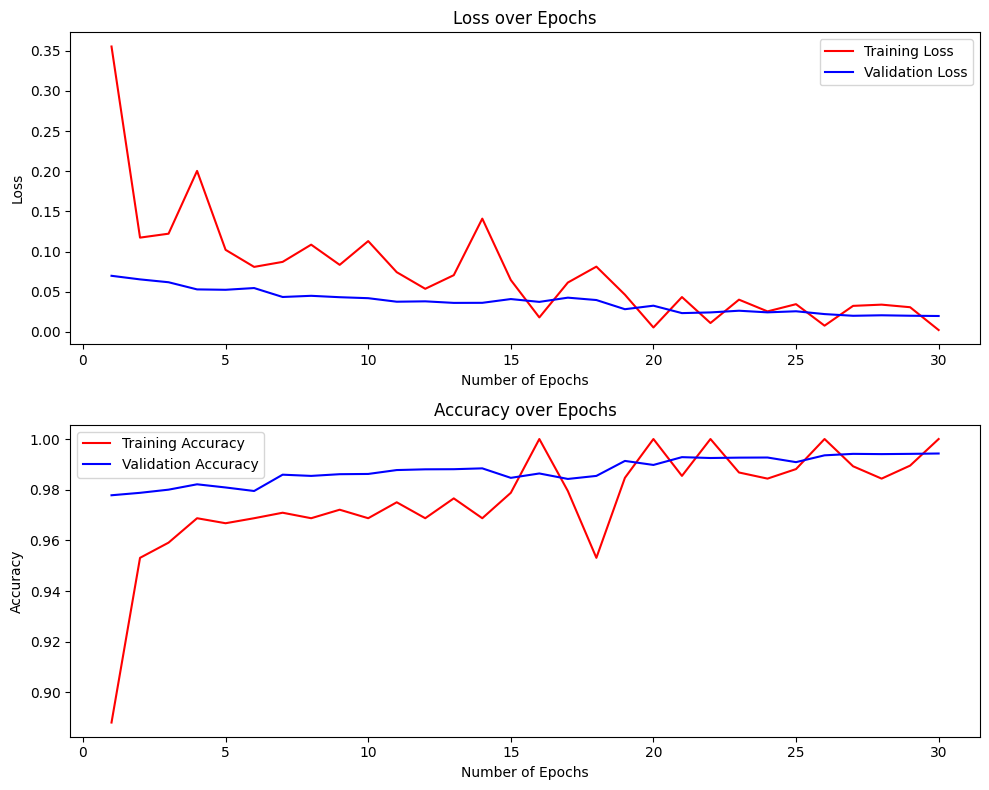

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

x = range(1, 1 + epochs)

# Plot training and validation loss
ax[0].plot(x, history.history['loss'], color='red', label='Training Loss')
ax[0].plot(x, history.history['val_loss'], color='blue', label='Validation Loss')
ax[0].set_title('Loss over Epochs')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and validation accuracy
ax[1].plot(x, history.history['accuracy'], color='red', label='Training Accuracy')
ax[1].plot(x, history.history['val_accuracy'], color='blue', label='Validation Accuracy')
ax[1].set_title('Accuracy over Epochs')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

In [30]:
pre_test_y = model.predict(test_X)
pre_test_y = np.argmax(pre_test_y, axis=1)
y_test = np.argmax(test_y, axis=1)

651/651 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step


In [31]:
# Generate the confusion matrix
conf = confusion_matrix(y_test, pre_test_y)
conf = pd.DataFrame(conf, index=range(0, 17), columns=range(0, 17))

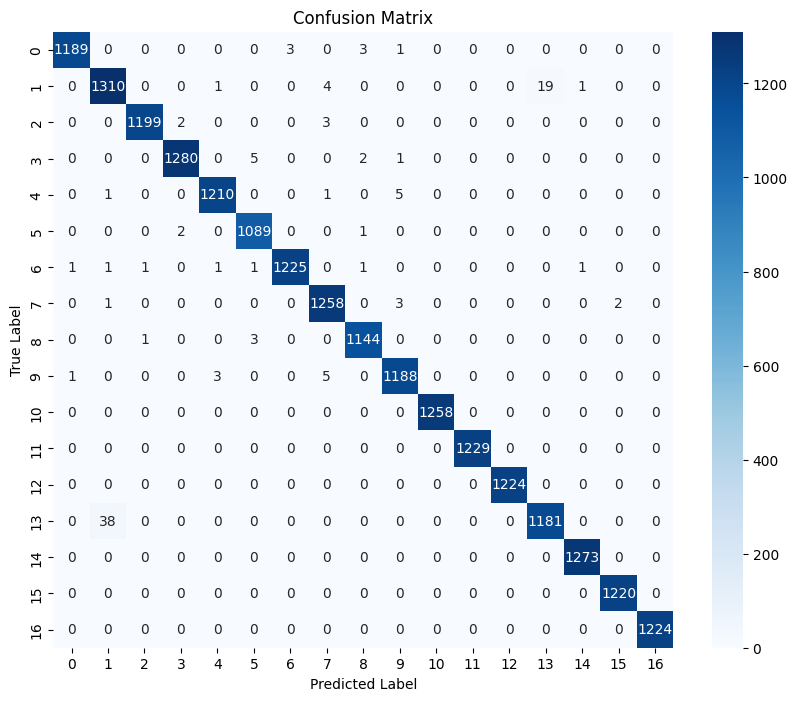

In [32]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=range(0, 17), yticklabels=range(0, 17))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()